In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 33.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=a72dd09a713c94b64cec773d403796c71cd028bb9328cba869d543652de23569
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pyspark

In [ ]:
!pip install firebase-admin

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore

In [ ]:
import pandas as pd


In [ ]:
import csv
import google.cloud

## Loading Raw Data to firestore

In [ ]:
def csv_to_firestore(path_for_csv, CollectionName):
  if not firebase_admin._apps:
    cred = credentials.Certificate('/content/drive/MyDrive/project551/serviceaccountkey.json')
    default_app = firebase_admin.initialize_app(cred)

  store = firestore.client()

  file_path = path_for_csv
  collection_name = CollectionName


  def batch_data(iterable, n=1):
    l = len(iterable)
    for ndx in range(0,l,n):
      yield iterable[ndx:min(ndx +n, l)]

  data = []
  headers = []

  with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter =',')
    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        for header in row:
          headers.append(header)
        line_count += 1
      else:
        obj = {}
        for idx, item in enumerate(row):
            obj[headers[idx]] = item
        data.append(obj)
        line_count += 1
    print(f'read {line_count} line')

    for batched_data in batch_data(data, 499):
      batch = store.batch()
      for data_item in batched_data:
        doc_ref = store.collection(collection_name).document()
        batch.set(doc_ref, data_item)
      batch.commit()



In [ ]:
csv_to_firestore('/content/drive/MyDrive/project551/order_products__prior.csv', 'orders_products_prior')

## Retrieving Datasets from Firestore

In [ ]:
def firestore_to_csv(CollectionName, path_for_csv):

  cred = credentials.Certificate('/content/drive/MyDrive/project551/serviceaccountkey.json')
  # default_app = firebase_admin.initialize_app(cred)
  # firebase_admin.initialize_app(cred)

  # firebase_admin.get_app()

  store = firestore.client()
  doc_ref = store.collection(u'{}'.format(CollectionName))


  data = []

  docs = doc_ref.get()

  for doc in docs:
    data.append(doc.to_dict())
  print(data[1])
  print(len(data))

  to_csv = data

  keys = to_csv[0].keys()
  with open(path_for_csv, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file,keys)
    dict_writer.writeheader()
    dict_writer.writerows(to_csv)


In [ ]:
firestore_to_csv('aisles','/content/drive/MyDrive/project551/from_firestore/prior.csv')

In [ ]:
# firestore_to_csv('products','/content/drive/MyDrive/project551/from_firestore/products.csv')

In [ ]:
# firestore_to_csv('departments','/content/drive/MyDrive/project551/from_firestore/departments.csv')

### Loading retrived datasets for EDA

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
aisles = pd.read_csv('/content/drive/MyDrive/project551/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/project551/departments.csv')
prior = pd.read_csv('/content/drive/MyDrive/project551/order_products__prior.csv')

train = pd.read_csv('/content/drive/MyDrive/project551/order_products__train.csv')
orders = pd.read_csv('/content/drive/MyDrive/project551/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/project551/products.csv')

In [ ]:
prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


## Data Exploration 

Merging all raw datasets into one. The combined dataset will be used for modeling

In [ ]:
# create merged dataframe of all orders

all_orders = pd.concat([prior,train],axis = 0)
all_orders = all_orders.merge(products[['product_id','aisle_id','department_id']], how = 'inner', on = 'product_id')
all_orders = all_orders.merge(aisles, on = 'aisle_id')
all_orders = all_orders.merge(departments, on = 'department_id')
all_orders = all_orders.merge(orders[['order_id','user_id']], on = 'order_id')
all_orders = all_orders.merge(products[['product_id','product_name']], on = 'product_id')

In [ ]:
all_orders

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id,product_name
0,2,33120,1,1,86,16,eggs,dairy eggs,202279,Organic Egg Whites
1,26,33120,5,0,86,16,eggs,dairy eggs,153404,Organic Egg Whites
2,120,33120,13,0,86,16,eggs,dairy eggs,23750,Organic Egg Whites
3,327,33120,5,1,86,16,eggs,dairy eggs,58707,Organic Egg Whites
4,390,33120,28,1,86,16,eggs,dairy eggs,166654,Organic Egg Whites
...,...,...,...,...,...,...,...,...,...,...
32444483,2440439,21440,2,0,101,17,air fresheners candles,household,45555,"Freshmatic Ultra Automatic Spray Refill, Vanil..."
32444484,3340423,46404,3,0,6,2,other,other,103807,Cotes De Provence Rose
32444485,3016581,46404,1,1,6,2,other,other,132609,Cotes De Provence Rose
32444486,3326955,46404,1,0,6,2,other,other,132609,Cotes De Provence Rose


Modifying dataset to keep only the required columns

In [ ]:
all_orders = all_orders[['order_id','add_to_cart_order','product_id','product_name','aisle_id','aisle','department_id','department','user_id']]
all_orders.head()

,order_id,add_to_cart_order,product_id,product_name,aisle_id,aisle,department_id,department,user_id
0,2,1,33120,Organic Egg Whites,86,eggs,16,dairy eggs,202279
1,26,5,33120,Organic Egg Whites,86,eggs,16,dairy eggs,153404
2,120,13,33120,Organic Egg Whites,86,eggs,16,dairy eggs,23750
3,327,5,33120,Organic Egg Whites,86,eggs,16,dairy eggs,58707
4,390,28,33120,Organic Egg Whites,86,eggs,16,dairy eggs,166654


Further Analysis of purchase pattern for user 1

In [ ]:
all_orders.loc[all_orders['user_id'] == 1] 


,order_id,add_to_cart_order,product_id,product_name,aisle_id,aisle,department_id,department,user_id
182811,2550362,7,35951,Organic Unsweetened Almond Milk,91,soy lactosefree,16,dairy eggs,1
6167997,431534,8,13176,Bag of Organic Bananas,24,fresh fruits,4,produce,1
6261053,2398795,4,13176,Bag of Organic Bananas,24,fresh fruits,4,produce,1
6532791,2295261,1,49235,Organic Half & Half,53,cream,16,dairy eggs,1
6532803,3108588,6,49235,Organic Half & Half,53,cream,16,dairy eggs,1
6904247,2539329,2,14084,Organic Unsweetened Vanilla Almond Milk,91,soy lactosefree,16,dairy eggs,1
10197135,431534,7,41787,Bartlett Pears,24,fresh fruits,4,produce,1
15828201,473747,5,30450,Creamy Almond Butter,88,spreads,13,pantry,1
16269178,431534,6,17122,Honeycrisp Apples,24,fresh fruits,4,produce,1
18134388,2550362,5,25133,Organic String Cheese,21,packaged cheese,16,dairy eggs,1


Descriptive Statistics

In [ ]:
# size of data stats

print(str(len(all_orders.user_id.unique())) +' customers')
print(str(len(all_orders.order_id.unique())) +' order')
print(str(len(all_orders.aisle_id.unique())) +' aisles')
print(str(len(all_orders.product_id.unique())) +' products')

206209 customers
3215813 order
134 aisles
49677 products


Checking distribution of Units ordered by Department

[Text(0, 0.5, 'Units Ordered'), Text(0.5, 0, 'Department')]

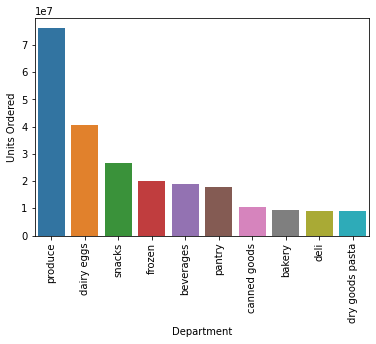

In [ ]:

# most popular departments in terms of units ordered

x = sns.barplot(data = all_orders.groupby('department')['add_to_cart_order'].sum().sort_values(ascending = False).reset_index()[0:10], x = 'department', y = 'add_to_cart_order')
x.set_xticklabels(x.get_xticklabels(), rotation = 90)
x.set(xlabel = 'Department', ylabel = 'Units Ordered')

In [ ]:
# department_share = all_orders.groupby('department')['add_to_cart_order'].sum().reset_index()
# department_share['department_share'] = department_share['add_to_cart_order']
# department_share['department_share'] = department_share['department_share'].apply(lambda x: x / department_share['add_to_cart_order'].sum())

# x = sns.barplot(data = department_share.sort_values(by = 'department_share',ascending = False), x = 'department', y = 'department_share')
# x.set_xticklabels(x.get_xticklabels(), rotation = 90)
# x.set(xlabel = 'Department', ylabel = 'Department Share')

In [ ]:
all_orders.department.nunique()

21

Checking unique aisle values

In [ ]:
all_orders.aisle.unique()

array(['eggs', 'fresh vegetables', 'packaged vegetables fruits',
       'spices seasonings', 'oils vinegars', 'baking ingredients',
       'doughs gelatins bake mixes', 'spreads', 'soy lactosefree',
       'fresh fruits', 'packaged poultry', 'frozen produce', 'yogurt',
       'packaged cheese', 'other creams cheeses', 'packaged produce',
       'soft drinks', 'crackers', 'cereal', 'hot cereal pancake mixes',
       'water seltzer sparkling water', 'tea', 'milk', 'fresh herbs',
       'honeys syrups nectars', 'pickled goods olives', 'refrigerated',
       'juice nectars', 'fresh dips tapenades', 'grains rice dried goods',
       'frozen appetizers sides', 'ice cream ice', 'frozen pizza',
       'pasta sauce', 'granola', 'latino foods', 'frozen breakfast',
       'dish detergents', 'instant foods', 'frozen meals',
       'canned jarred vegetables', 'laundry', 'cream',
       'hot dogs bacon sausage', 'energy granola bars',
       'fruit vegetable snacks', 'coffee', 'canned meals beans',


In [ ]:
all_orders.to_csv('all_orders.csv')
#path = /content/all_orders.csv

First we perform K Means Clustering using python sklearn library so that we can visualise the cluster and features. 

Transforming dataset for Modeling

In [ ]:
all_orders.columns

Index(['order_id', 'add_to_cart_order', 'product_id', 'product_name',
       'aisle_id', 'aisle', 'department_id', 'department', 'user_id'],
      dtype='object')

In [ ]:
aisle_hist = all_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
dept_hist = all_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()

In [ ]:

user_volume = aisle_hist.groupby('user_id')['add_to_cart_order'].sum()
user_volume = user_volume.reset_index().rename(columns = {'add_to_cart_order':'volume'})
aisle_hist = aisle_hist.merge(user_volume, how = 'inner', on = 'user_id')
dept_hist = dept_hist.merge(user_volume, how = 'inner', on = 'user_id')

In [ ]:
aisle_hist

,user_id,aisle,add_to_cart_order,volume
0,1,candy chocolate,3,214
1,1,cereal,19,214
2,1,cream,7,214
3,1,fresh fruits,30,214
4,1,nuts seeds dried fruit,30,214
...,...,...,...,...
5730610,206209,soft drinks,25,876
5730611,206209,soy lactosefree,18,876
5730612,206209,spices seasonings,9,876
5730613,206209,trash bags liners,6,876


In [ ]:
aisle_hist['aisle_share'] = aisle_hist['add_to_cart_order'] / aisle_hist['volume']
dept_hist['dept_share'] = dept_hist['add_to_cart_order'] / dept_hist['volume']

In [ ]:
aisle_vol_pivot = aisle_hist[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
aisle_share_pivot = aisle_hist[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
dept_vol_pivot = dept_hist[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
dept_share_pivot = dept_hist[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')

In [ ]:
aisle_vol_pivot = aisle_hist[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
aisle_share_pivot = aisle_hist[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
dept_vol_pivot = dept_hist[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
dept_share_pivot = dept_hist[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')
aisle_vol_pivot = aisle_vol_pivot.fillna(value = 0)
aisle_share_pivot = aisle_share_pivot.fillna(value = 0)
dept_vol_pivot = dept_vol_pivot.fillna(value = 0)
dept_share_pivot = dept_share_pivot.fillna(value = 0)

In [ ]:
all_orders

In [ ]:
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.014019,0.0,0.000000,0.000000,0.000000,0.0,0.088785,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.032710,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046729,0.000000,0.000000,0.000000,0.196262,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.107477,0.000000,0.042056,0.000000,0.00,0.000000,0.0,0.023364,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.018692
2,0.0,0.013789,0.000000,0.0,0.000000,0.0,0.005396,0.00000,0.0,0.0,0.0,0.005396,0.011391,0.007794,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.001799,0.0,0.000000,0.052758,0.000000,0.0,0.000000,0.0,0.007794,0.000000,0.048561,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.007194,0.000000,0.000000,0.020983,0.000000,0.000000,0.009592,0.000000,0.007794,0.000000,0.000000,0.002998,0.000000,0.0,0.00,0.025180,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000600,0.000000,0.00,0.000000,0.0,0.029976,0.004197,0.008993,0.000000,0.00000,0.000000,0.0,0.010791,0.0,0.241607
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.117647,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.168798,0.012788,0.000000,0.000000,0.000000,0.000000,0.000000,0.028133,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.092072,0.000000,0.00,0.000000,0.0,0.038363,0.012788,0.000000,0.000000,0.00000,0.000000,0.0,0.028133,0.0,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.020000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.020000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.080000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.02,0.040000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.040000,0.020000,0.000000,0.000000,0.02,0.000000,0.0,0.000000,0.000000,0.000000,0.060000,0.00000,0.000000,0.0,0.040000,0.0,0.000000
5,0.0,0.039216,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.039216,0.000000,0.000000,0.0,0.000000,0.039216,0.000000,0.0,0.000000,0.0,0.00000

## PCA for feature reduction
Since our dataset contains many variables, we perform dimensionality reduction using PCA and visualise the features of the dataset

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Checking the weightage of the first 10 principal components 

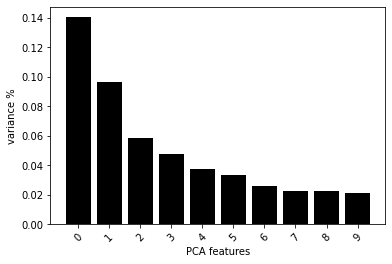

In [ ]:
pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(aisle_share_pivot)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.xticks(rotation = 45)

PCA_components = pd.DataFrame(principalComponents)

Projecting the dataset into a two dimensional plane for visualization

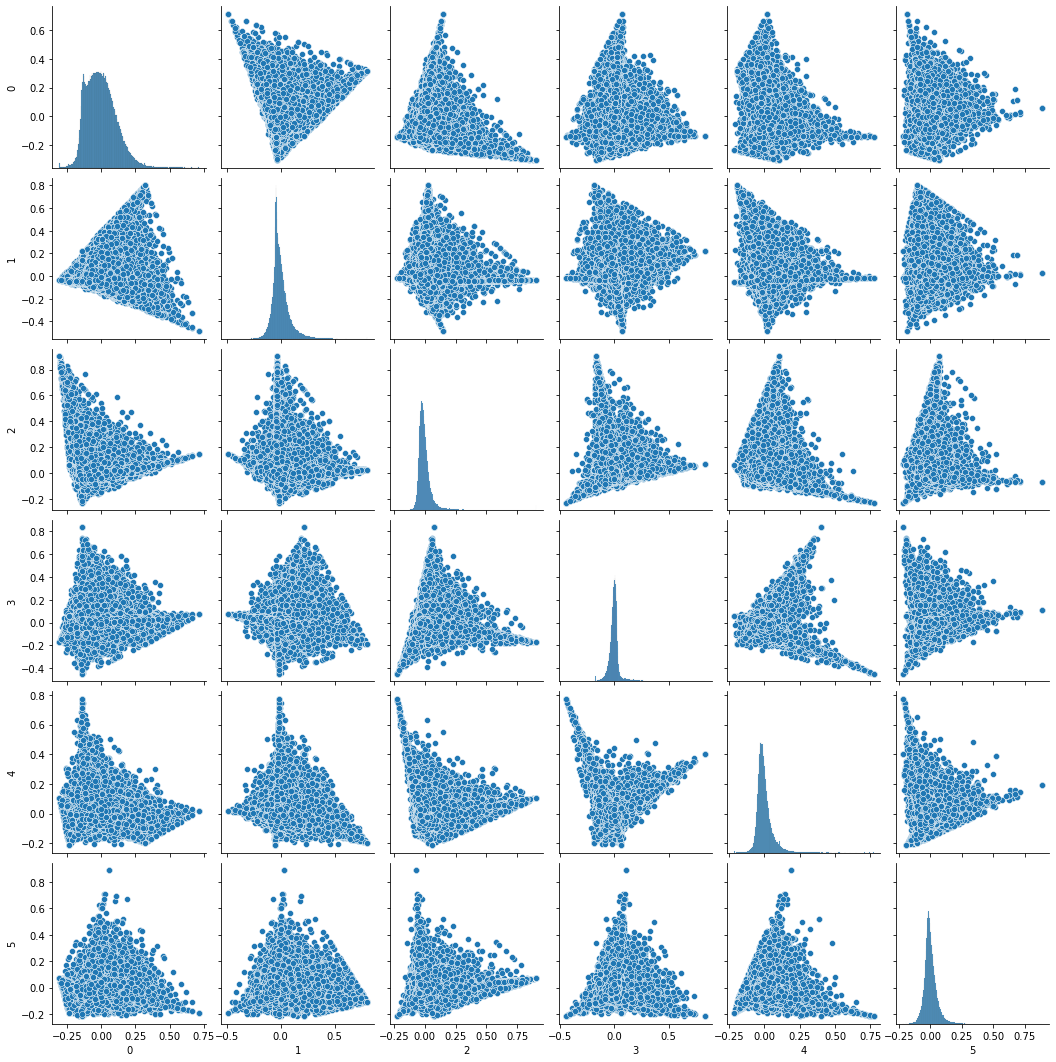

In [ ]:
sns.pairplot(PCA_components[[0,1,2,3,4,5]])

### K Means Clustering - Sklearn

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


Plotting number of cluster vs SSE (Sum of Squared Error metrics)

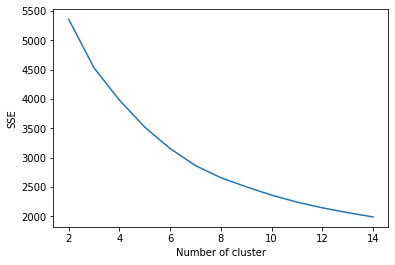

In [ ]:
sse = {}
labels = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3,4,5]])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
cluster_df = pd.concat([PCA_components[[0,1,2,3,4,5]],pd.Series(labels[6]).rename('cluster')], axis = 1)
# sns.pairplot(cluster_df, hue = 'cluster')

In [ ]:
cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)
cluster_df

,user_id,0,1,2,3,4,5,cluster
0,1,-0.084261,0.076234,-0.031024,-0.007998,-0.062301,-0.046623,1
1,2,-0.071139,0.091476,-0.078774,-0.129372,0.129017,-0.050214,1
2,3,0.058400,0.085563,0.002129,-0.011113,-0.025842,0.113689,2
3,4,-0.053379,0.136516,-0.000474,-0.035603,-0.087318,-0.027157,3
4,5,0.145132,-0.016538,-0.020891,-0.016541,0.062319,0.102969,0
...,...,...,...,...,...,...,...,...
206204,206205,-0.047239,-0.002151,-0.083345,-0.086290,0.219417,-0.087587,1
206205,206206,-0.040415,-0.036053,-0.024377,0.009657,-0.051477,0.001485,1
206206,206207,-0.022042,-0.032433,-0.009095,-0.016393,0.021234,0.019805,2
206207,206208,-0.002154,-0.010690,-0.037634,-0.008405,0.029376,0.044724,2


In [ ]:
aisle_hist

,user_id,aisle,add_to_cart_order,volume,aisle_share
0,1,candy chocolate,3,214,0.014019
1,1,cereal,19,214,0.088785
2,1,cream,7,214,0.032710
3,1,fresh fruits,30,214,0.140187
4,1,nuts seeds dried fruit,30,214,0.140187
...,...,...,...,...,...
5730610,206209,soft drinks,25,876,0.028539
5730611,206209,soy lactosefree,18,876,0.020548
5730612,206209,spices seasonings,9,876,0.010274
5730613,206209,trash bags liners,6,876,0.006849


In [ ]:
cluster_aisle_br = aisle_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
cluster_aisle_br = cluster_aisle_br.rename(columns = {'aisle_share':'user_aisle_share'})
aisle_hist = aisle_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
aisle_hist = aisle_hist.rename(columns = {'aisle_share':'user_aisle_share'})
dept_hist = dept_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
dept_hist = dept_hist.rename(columns = {'dept_share':'user_dept_share'})

In [ ]:
cluster_aisle_br = pd.DataFrame(columns = ['aisle','add_to_cart_order','aisle_share','cluster'])
for i in range(0,6):
    x = aisle_hist[aisle_hist['cluster'] == i]
    x = x.groupby('aisle')['add_to_cart_order'].sum().reset_index()
    x['aisle_share'] = x['add_to_cart_order']
    x['aisle_share'] = x['aisle_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_aisle_br = pd.concat([x,cluster_aisle_br], axis = 0)

In [ ]:
cluster_aisle_br

,aisle,add_to_cart_order,aisle_share,cluster
0,air fresheners candles,952,0.000990,5
1,asian foods,2863,0.002978,5
2,baby accessories,104,0.000108,5
3,baby bath body care,72,0.000075,5
4,baby food formula,1265,0.001316,5
...,...,...,...,...
129,trash bags liners,19817,0.000468,0
130,vitamins supplements,50343,0.001188,0
131,water seltzer sparkling water,530499,0.012524,0
132,white wines,4153,0.000098,0


In [ ]:
cluster_aisle_br.cluster.nunique()

6

In [ ]:
aisle_hist

,user_id,aisle,add_to_cart_order,volume,user_aisle_share,cluster
0,1,candy chocolate,3,214,0.014019,1
1,1,cereal,19,214,0.088785,1
2,1,cream,7,214,0.032710,1
3,1,fresh fruits,30,214,0.140187,1
4,1,nuts seeds dried fruit,30,214,0.140187,1
...,...,...,...,...,...,...
5730610,206209,soft drinks,25,876,0.028539,1
5730611,206209,soy lactosefree,18,876,0.020548,1
5730612,206209,spices seasonings,9,876,0.010274,1
5730613,206209,trash bags liners,6,876,0.006849,1


In [ ]:
pd.DataFrame(cluster_df['cluster'].value_counts().reset_index())

,index,cluster
0,1,74352
1,2,73040
2,0,32399
3,3,14789
4,4,7816
5,5,3813


In [ ]:
# is_0 =  pandasDF['prediction']==0
# print(cluster_aisle_br[cluster_aisle_br["cluster"] == 1]["aisle"])

cluster_0 =  cluster_aisle_br['cluster']==0
cluster_1 =  cluster_aisle_br['cluster']==1
cluster_2 =  cluster_aisle_br['cluster']==2
cluster_3 =  cluster_aisle_br['cluster']==3
cluster_4 =  cluster_aisle_br['cluster']==4
cluster_5 =  cluster_aisle_br['cluster']==5


aisle_0 = cluster_aisle_br[cluster_0]
aisle_1 = cluster_aisle_br[cluster_1]
# aisle_1
aisle_2 = cluster_aisle_br[cluster_2]
aisle_3 = cluster_aisle_br[cluster_3]
aisle_4 = cluster_aisle_br[cluster_4]
aisle_5 = cluster_aisle_br[cluster_5]
# df_is_0['aisle'].unique

a0 = aisle_0['aisle'].unique()
a1 = aisle_1['aisle'].unique()
a2 = aisle_2['aisle'].unique()
a3 = aisle_3['aisle'].unique()
a4 = aisle_4['aisle'].unique()
a5 = aisle_5['aisle'].unique()


print("cluster 0 - ", sorted(a0))
print("\n")
print("cluster 1 - ",sorted(a1))
print("\n")
print("cluster 2 - ", sorted(a2))
print("\n")
print("cluster 3 - ",sorted(a3))
print("\n")
print("cluster 4 - ",sorted(a4))
print("\n")
print("cluster 5 - ",sorted(a5))

cluster 0 -  ['air fresheners candles', 'asian foods', 'baby accessories', 'baby bath body care', 'baby food formula', 'bakery desserts', 'baking ingredients', 'baking supplies decor', 'beauty', 'beers coolers', 'body lotions soap', 'bread', 'breakfast bakery', 'breakfast bars pastries', 'bulk dried fruits vegetables', 'bulk grains rice dried goods', 'buns rolls', 'butter', 'candy chocolate', 'canned fruit applesauce', 'canned jarred vegetables', 'canned meals beans', 'canned meat seafood', 'cat food care', 'cereal', 'chips pretzels', 'cleaning products', 'cocoa drink mixes', 'coffee', 'cold flu allergy', 'condiments', 'cookies cakes', 'crackers', 'cream', 'deodorants', 'diapers wipes', 'digestion', 'dish detergents', 'dog food care', 'doughs gelatins bake mixes', 'dry pasta', 'eggs', 'energy granola bars', 'energy sports drinks', 'eye ear care', 'facial care', 'feminine care', 'first aid', 'food storage', 'fresh dips tapenades', 'fresh fruits', 'fresh herbs', 'fresh pasta', 'fresh veg

The Clustering model gives us 6 clusters but since we already noted that we only can map our image model to 4 categories, we run the Spark Mlib K Means model for 4 cluster. 

# Spark MLib Model 

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('mlearnsample').getOrCreate()
df = spark.read.csv('/content/all_orders.csv', header = True, inferSchema = True)
df.printSchema()




root
 |-- _c0: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- product_name: string (nullable = true)



In [ ]:

from pyspark.ml.feature import  Bucketizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, BisectingKMeans
import glob

In [ ]:
all_orders.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id',
       'department_id', 'aisle', 'department', 'user_id', 'product_name'],
      dtype='object')

## Feature Extraction using Spark

StringIndexer encodes a string column of labels to a column of label indices. Hence we use StringIndexer to encode aisle_id column i.e a string

In [ ]:
from pyspark.ml.feature import StringIndexer
aisle_indexer = StringIndexer(inputCol="aisle_id", outputCol="aisleid")
#Fits a model to the input dataset with optional parameters.
df = aisle_indexer.fit(df).transform(df)


VectorAssembler is a transformer that combines a given list of columns into a single vector column.It combines raw features and features generated by different feature transformers into a single feature vector, in order to the train ML model. 

In [ ]:
# Coverting the input data into features column
vectorAssembler = VectorAssembler(inputCols = ['aisleid','order_id', 'add_to_cart_order', 'product_id', 'department_id','user_id'], outputCol = "features")
vdf = vectorAssembler.transform(df)
vdf.show(10)

+---+--------+----------+-----------------+---------+--------+-------------+-----+----------+-------+------------------+-------+--------------------+
|_c0|order_id|product_id|add_to_cart_order|reordered|aisle_id|department_id|aisle|department|user_id|      product_name|aisleid|            features|
+---+--------+----------+-----------------+---------+--------+-------------+-----+----------+-------+------------------+-------+--------------------+
|  0|       2|     33120|                1|        1|      86|           16| eggs|dairy eggs| 202279|Organic Egg Whites|   15.0|[15.0,2.0,1.0,331...|
|  1|      26|     33120|                5|        0|      86|           16| eggs|dairy eggs| 153404|Organic Egg Whites|   15.0|[15.0,26.0,5.0,33...|
|  2|     120|     33120|               13|        0|      86|           16| eggs|dairy eggs|  23750|Organic Egg Whites|   15.0|[15.0,120.0,13.0,...|
|  3|     327|     33120|                5|        1|      86|           16| eggs|dairy eggs|  58707

KMean from Mlib is used for Clustering

In [ ]:
# Trains a k-means model.

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Applying the k-means algorithm
kmeans = KMeans().setK(4)
kmeans = kmeans.setSeed(1)
kmodel = kmeans.fit(vdf)

In [ ]:
centers = kmodel.clusterCenters()
print("The location of centers: {}".format(centers))

The location of centers: [array([2.23388708e+01, 4.30044925e+05, 8.34753527e+00, 2.55780128e+04,
       9.92123164e+00, 1.02969016e+05]), array([2.23408944e+01, 1.29042355e+06, 8.36015412e+00, 2.55792303e+04,
       9.92413660e+00, 1.02919707e+05]), array([2.23605445e+01, 2.99621922e+06, 8.34333892e+00, 2.55770147e+04,
       9.91809081e+00, 1.02867725e+05]), array([2.23550666e+01, 2.14531926e+06, 8.35436204e+00, 2.55711466e+04,
       9.92413892e+00, 1.02989616e+05])]


In [ ]:
predictions = kmodel.transform(vdf)

In [ ]:
predictions

DataFrame[_c0: int, order_id: int, product_id: int, add_to_cart_order: int, reordered: int, aisle_id: int, department_id: int, aisle: string, department: string, user_id: int, product_name: string, aisleid: double, features: vector, prediction: int]

In [ ]:
pandasDF=predictions.toPandas()
# pandasDF

## Cluster 0

In [ ]:
is_0 =  pandasDF['prediction']==0
df_is_0 = pandasDF[is_0]
# df_is_0['aisle'].unique

a0 = df_is_0['aisle'].unique()
print(sorted(a0))

['bread', 'candy chocolate', 'canned fruit applesauce', 'canned jarred vegetables', 'chips pretzels', 'coffee', 'condiments', 'cookies cakes', 'crackers', 'cream', 'dry pasta', 'eggs', 'fresh herbs', 'fresh vegetables', 'frozen appetizers sides', 'frozen breakfast', 'frozen produce', 'fruit vegetable snacks', 'hot cereal pancake mixes', 'juice nectars', 'lunch meat', 'milk', 'nuts seeds dried fruit', 'packaged cheese', 'packaged vegetables fruits', 'pickled goods olives', 'prepared meals', 'preserved dips spreads', 'refrigerated', 'soy lactosefree', 'spices seasonings', 'tea', 'water seltzer sparkling water', 'yogurt']


In [ ]:
df_is_0

,_c0,order_id,add_to_cart_order,product_id,product_name,aisle_id,aisle,department_id,department,user_id,features,prediction
0,0,5640,9,33120,Organic Egg Whites,86,eggs,16,dairy eggs,155,"[5640.0, 9.0, 33120.0, 86.0, 16.0, 155.0]",0
8,8,5640,3,35522,Strawberry Protein Shake,98,juice nectars,7,beverages,155,"[5640.0, 3.0, 35522.0, 98.0, 7.0, 155.0]",0
10,10,5640,10,30795,Sesame Seaweed Salad,13,prepared meals,20,deli,155,"[5640.0, 10.0, 30795.0, 13.0, 20.0, 155.0]",0
13,13,5640,4,31869,Organic Edamame,116,frozen produce,1,frozen,155,"[5640.0, 4.0, 31869.0, 116.0, 1.0, 155.0]",0
14,14,5640,2,28137,Chicken & Vegetable Dumplings Potstickers,129,frozen appetizers sides,1,frozen,155,"[5640.0, 2.0, 28137.0, 129.0, 1.0, 155.0]",0
32,32,280,6,30233,Organic Large Brown Grade AA Cage Free Eggs,86,eggs,16,dairy eggs,1059,"[280.0, 6.0, 30233.0, 86.0, 16.0, 1059.0]",0
34,34,280,1,29672,Lactose Free Low Fat Vanilla Yogurt,120,yogurt,16,dairy eggs,1059,"[280.0, 1.0, 29672.0, 120.0, 16.0, 1059.0]",0
47,47,280,26,31717,Organic Cilantro,16,fresh herbs,4,produce,1059,"[280.0, 26.0, 31717.0, 16.0, 4.0, 1059.0]",0
53,53,280,12,36792,Gluten Free Omega Flax & Fiber Bread,112,bread,3,bakery,1059,"[280.0, 12.0, 36792.0, 112.0, 3.0, 1059.0]",0
57,57,280,18,31238,Blue Corn Tortilla Chips,107,chips pretzels,19,snacks,1059,"[280.0, 18.0, 31238.0, 107.0, 19.0, 1059.0]",0


In [ ]:
df_is_0.to_csv('Snacks.csv')
#/content/all_orders.csv

## Cluster 1

In [ ]:
is_1 =  pandasDF['prediction']==1
df_is_1 = pandasDF[is_1]
df_is_1['aisle'].unique



<bound method Series.unique of 26            fresh fruits
27            fresh fruits
28            fresh fruits
30            fresh fruits
33                  yogurt
              ...         
323    energy granola bars
328    energy granola bars
331                granola
332                 cereal
342      baby food formula
Name: aisle, Length: 78, dtype: object>

In [ ]:
a1 = df_is_1['aisle'].unique()
print(sorted(a1))

['baby food formula', 'bakery desserts', 'baking ingredients', 'beers coolers', 'bread', 'breakfast bakery', 'cereal', 'chips pretzels', 'crackers', 'cream', 'digestion', 'energy granola bars', 'fresh fruits', 'fresh vegetables', 'frozen appetizers sides', 'frozen breakfast', 'frozen pizza', 'frozen produce', 'fruit vegetable snacks', 'granola', 'hot cereal pancake mixes', 'juice nectars', 'lunch meat', 'meat counter', 'milk', 'oils vinegars', 'other creams cheeses', 'packaged cheese', 'packaged poultry', 'packaged vegetables fruits', 'pickled goods olives', 'refrigerated', 'salad dressing toppings', 'soup broth bouillon', 'soy lactosefree', 'spices seasonings', 'spreads', 'tea', 'tofu meat alternatives', 'tortillas flat bread', 'water seltzer sparkling water', 'yogurt']


In [ ]:
df_is_1.to_csv('Bakery.csv')
#/content/all_orders.csv

## Cluster 2

In [ ]:
is_3 =  pandasDF['prediction']==3
df_is_3 = pandasDF[is_3]
# df_is_2['aisle'].unique

a3 = df_is_3['aisle'].unique()
print(sorted(a3))

['bread', 'breakfast bakery', 'chips pretzels', 'dog food care', 'fresh fruits', 'fresh vegetables', 'lunch meat', 'milk', 'other creams cheeses', 'packaged poultry', 'packaged vegetables fruits', 'pasta sauce', 'popcorn jerky', 'soft drinks', 'soy lactosefree', 'yogurt']


In [ ]:
df_is_3.to_csv('Beverages.csv')
#/content/all_orders.csv

## Cluster 4

In [ ]:
is_5 =  pandasDF['prediction']==5
df_is_5 = pandasDF[is_5]
# df_is_2['aisle'].unique

a5 = df_is_5['aisle'].unique()
print(sorted(a5))

['asian foods', 'baking ingredients', 'body lotions soap', 'bread', 'breakfast bars pastries', 'cereal', 'coffee', 'cream', 'doughs gelatins bake mixes', 'fresh dips tapenades', 'fresh fruits', 'fresh herbs', 'fresh vegetables', 'frozen meals', 'frozen pizza', 'frozen produce', 'frozen vegan vegetarian', 'fruit vegetable snacks', 'hot cereal pancake mixes', 'hot dogs bacon sausage', 'ice cream ice', 'juice nectars', 'lunch meat', 'marinades meat preparation', 'oils vinegars', 'other creams cheeses', 'packaged cheese', 'packaged vegetables fruits', 'paper goods', 'poultry counter', 'prepared soups salads', 'refrigerated', 'soft drinks', 'soy lactosefree', 'specialty cheeses', 'spreads', 'tea', 'water seltzer sparkling water', 'yogurt']


In [ ]:
df_is_5.to_csv('pantry.csv')
#/content/all_orders.csv

### The categories we will be focusing on are 
1. Snacks
2. Pantry
3. Beverages
4. Bakery


# Image Classification Model

In [2]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler


In [3]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    # ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    # ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [4]:
def label_assignment(img,label):

    return label



def training_data(label,data_dir):
    
    
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)

        img = cv2.imread(path,cv2.IMREAD_COLOR)

        img = cv2.resize(img,(imgsize,imgsize))
        X.append(np.array(img))
        Z.append(str(label))
    L.append(str(label))

In [5]:
# beans = '/content/drive/MyDrive/project551/images_new/BEANS'
cake = '/content/drive/MyDrive/project551/images_new/CAKE'
candy = '/content/drive/MyDrive/project551/images_new/CANDY'
# cereal = '../input/repository/abhinavsagar-grocery-c457bd9/CEREAL'
chips = '/content/drive/MyDrive/project551/images_new/CHIPS'
chocolate = '/content/drive/MyDrive/project551/images_new/CHOCOLATE'
coffee = '/content/drive/MyDrive/project551/images_new/COFFEE'
# corn = '../input/repository/abhinavsagar-grocery-c457bd9/CORN'
# fish = '../input/repository/abhinavsagar-grocery-c457bd9/FISH'
flour = '/content/drive/MyDrive/project551/images_new/FLOUR'
honey = '/content/drive/MyDrive/project551/images_new/HONEY'
jam = '/content/drive/MyDrive/project551/images_new/JAM'
juice = '/content/drive/MyDrive/project551/images_new/JUICE'
milk = '/content/drive/MyDrive/project551/images_new/MILK'
nuts = '/content/drive/MyDrive/project551/images_new/NUTS'
oil = '/content/drive/MyDrive/project551/images_new/OIL'
pasta = '/content/drive/MyDrive/project551/images_new/PASTA'
rice = '/content/drive/MyDrive/project551/images_new/RICE'
soda = '/content/drive/MyDrive/project551/images_new/SODA'
spices = '/content/drive/MyDrive/project551/images_new/SPICES'
sugar = '/content/drive/MyDrive/project551/images_new/SUGAR'
tea = '/content/drive/MyDrive/project551/images_new/TEA'
# tomato_sauce = '/content/drive/MyDrive/project551/images_new/TOMATO_SAUCE'
# vinegar = '/content/drive/MyDrive/project551/images_new/VINEGAR'
water = '/content/drive/MyDrive/project551/images_new/WATER'

X = []
Z = []

L=[]
imgsize = 150

In [6]:
# training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
# training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
# training_data('corn',corn)
# training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('psata',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
# # training_data('tomato sauce',tomato_sauce)
# # training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:59<00:00,  4.38it/s]


In [7]:
L

['cake',
 'candy',
 'chips',
 'chocolate',
 'coffee',
 'flour',
 'honey',
 'jam',
 'juice',
 'milk',
 'nuts',
 'oil',
 'psata',
 'rice',
 'soda',
 'spices',
 'sugar',
 'tea',
 'water']

In [8]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y,25)
X = np.array(X)
X=X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [9]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

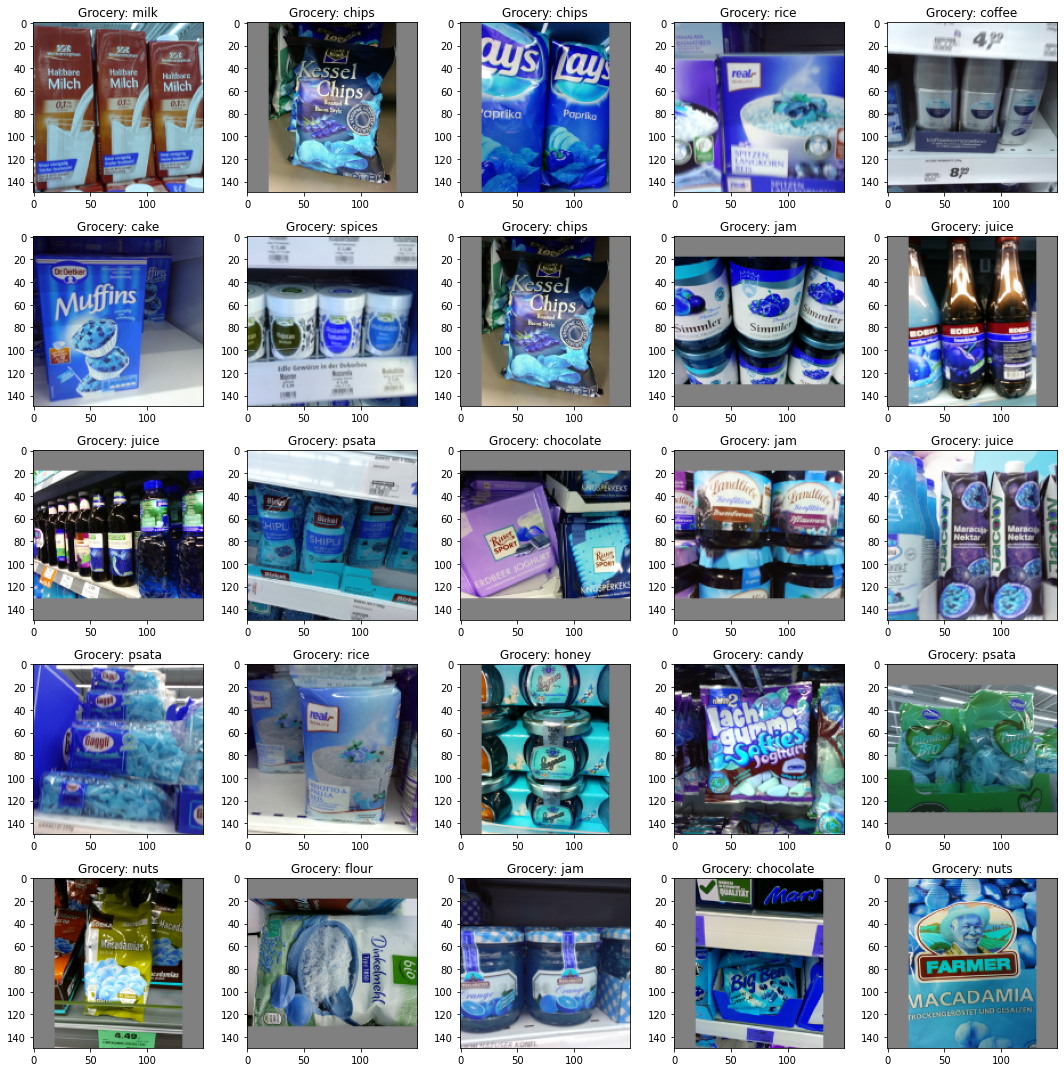

In [10]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Grocery: '+Z[l])
        
plt.tight_layout()

58900480/58889256 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fc8a73ccd50> False
<keras.layers.convolutional.Conv2D object at 0x7fc8b0994b50> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a7852d10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8a73bd890> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a0158050> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a73c37d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8a0163f90> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a0158950> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a786d1d0> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a016d0d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc8a016ae90> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a0158d90> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a0174a90> False
<keras.layers.convolutional.Conv2D object at 0x7fc8a017a650> F

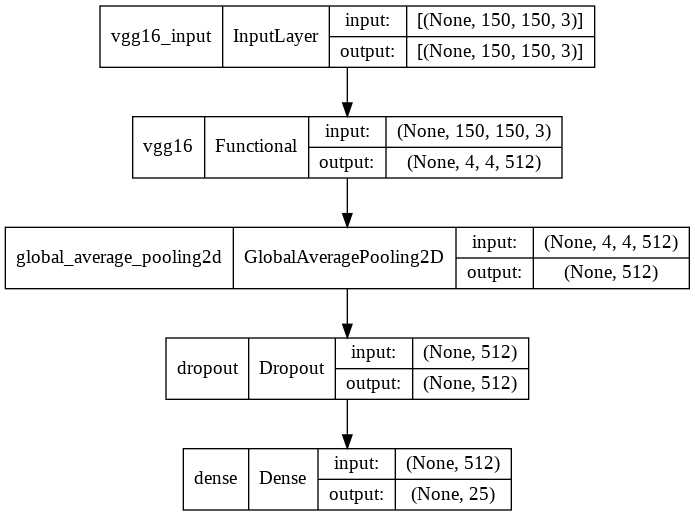

In [11]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(25,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# checkpoint_path= "train_ckpt/cp.ckpt"
checkpoint = ModelCheckpoint('CIFAR10{epoch:02d}.h5',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [30]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=128),
    validation_data  = (x_test,y_test),
    validation_steps = 100,
    steps_per_epoch  = 10,
    epochs = 25, 
    verbose = 1
    # callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/25
10/10 [==============================] - 20s 2s/step - loss: 2.2107 - accuracy: 0.3765 - val_loss: 2.0839 - val_accuracy: 0.4239
Epoch 2/25
10/10 [==============================] - 8s 734ms/step - loss: 2.1969 - accuracy: 0.3705
Epoch 3/25
10/10 [==============================] - 8s 758ms/step - loss: 2.1495 - accuracy: 0.3782
Epoch 4/25
10/10 [==============================] - 8s 762ms/step - loss: 2.1979 - accuracy: 0.3549
Epoch 5/25
10/10 [==============================] - 8s 846ms/step - loss: 2.1446 - accuracy: 0.3877
Epoch 6/25
10/10 [==============================] - 9s 827ms/step - loss: 2.1420 - accuracy: 0.3773
Epoch 7/25
10/10 [==============================] - 9s 824ms/step - loss: 2.1060 - accuracy: 0.3938
Epoch 8/25
10/10 [==============================] - 9s 836ms/step - loss: 2.1345 - accuracy: 0.3789
Epoch 9/25
10/10 [==============================] - 9s 832ms/step - loss: 2.1163 - accuracy: 0.3914
Epoch 10/25
10/10 [==============================] - 9s 860m

Weights Saved


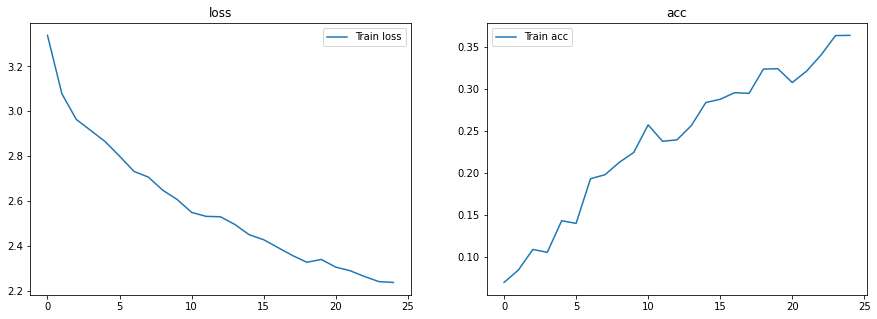

In [14]:
show_final_history(history)
model.save_weights('CIFAR1005.h5')
model.load_weights('CIFAR1005.h5')


model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

honey


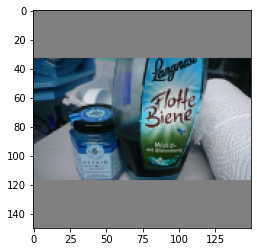

In [15]:
import cv2
img = cv2.imread('/content/drive/MyDrive/project551/images_new/HONEY/HONEY0000.png')
img = cv2.resize(img,(150,150))
plt.imshow(img)
img = np.reshape(img,[-1,150,150,3])

classes = model.predict(img)

# print(classes)
print(L[np.argmax(classes)])
plt.show()



In [17]:
L

['cake',
 'candy',
 'chips',
 'chocolate',
 'coffee',
 'flour',
 'honey',
 'jam',
 'juice',
 'milk',
 'nuts',
 'oil',
 'psata',
 'rice',
 'soda',
 'spices',
 'sugar',
 'tea',
 'water']

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving CAKE0005.png to CAKE0005 (1).png


In [ ]:
# print(x)

cake


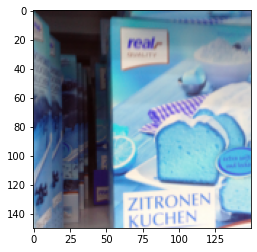

In [ ]:

img = cv2.imread('CAKE0019.png')
img = cv2.resize(img,(150,150))
plt.imshow(img)
img = np.reshape(img,[-1,150,150,3])

classes1 = model.predict(img)


# print(classes1)
print(L[np.argmax(classes1)])
# plt.show()



In [ ]:
y = L[np.argmax(classes1)]
y

'cake'

Recommendations are being fetched from the clustering model. 

In [ ]:
if y == 'milk':
  print("Recommendations", a3)

elif y == 'cake':
  print("Recommendations", a1)

elif y == 'flour':
  print("Recommendations", a5)

elif y == 'chips':
  print("Recommendations", a0)
else:
  print("Uploaded picture cannot be recognised, please try again")

Recommendations ['baby food formula', 'bakery desserts', 'baking ingredients', 'beers coolers', 'bread', 'breakfast bakery', 'cereal', 'chips pretzels', 'crackers', 'cream', 'digestion', 'energy granola bars', 'fresh fruits', 'fresh vegetables', 'frozen appetizers sides', 'frozen breakfast', 'frozen pizza', 'frozen produce', 'fruit vegetable snacks', 'granola', 'hot cereal pancake mixes', 'juice nectars', 'lunch meat', 'meat counter', 'milk', 'oils vinegars', 'other creams cheeses', 'packaged cheese', 'packaged poultry', 'packaged vegetables fruits', 'pickled goods olives', 'refrigerated', 'salad dressing toppings', 'soup broth bouillon', 'soy lactosefree', 'spices seasonings', 'spreads', 'tea', 'tofu meat alternatives', 'tortillas flat bread', 'water seltzer sparkling water', 'yogurt']


Saving recommendation file

In [ ]:
import numpy as np
np.savetxt("Recommendations_Bakery.csv", 
           a1,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("Recommendations_Beverages.csv", 
           a3,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("Recommendations_Pantry.csv", 
           a5,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("Recommendations_Snacks.csv", 
           a0,
           delimiter =", ", 
           fmt ='% s')

The Image Classification model is downloaded as a .pkl file using pickle model and integrated with the UI

In [31]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# with open('model_pkl', 'wb') as files:
#     pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://982984a6-57eb-490a-ba3a-639c68188af0/assets
